Analysis of the models obtain previously

In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context('paper', font_scale=1.4)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [2]:
iters = 100
subselection = True
mode = "admission"

In [3]:
outcomes = pd.read_csv('data/mimic/outcomes_first_day{}.csv'.format('_subselection' if subselection else ''), index_col = 0)
outcomes['Death'] = ~outcomes.Death.isna()

In [4]:
if mode == "admission":
    results_weekend = 'results{}/mimic/weekends/'.format('_subselection' if subselection else '') # Train only on weekends but test on both
    results_weekdays  = 'results{}/mimic/weekdays/'.format('_subselection' if subselection else '') # Train only on weekdays but test on both
    periods = ["Weekend", "Weekday"]
elif mode == "gender":
    results_weekend = 'results{}/mimic/female/'.format('_subselection' if subselection else '')
    results_weekdays  = 'results{}/mimic/male/'.format('_subselection' if subselection else '')
    periods = ["Female", "Male"]
# Random split
results_random  = 'results{}/mimic/random/'.format('_subselection' if subselection else '')

# Open results

In [5]:
import os

In [6]:
predictions = {}
root = 'survival_'
for period, results in zip(periods + ["Random"], [results_weekend, results_weekdays, results_random]):
    predictions[period] = {}
    print(period)
    for file in sorted(os.listdir(results)):
        if (root not in file) or ('.csv' not in file) or ('under' in file):
            continue
        
        name = file[file.index(root)+len(root):file.rindex('.csv')]
        predictions[period][name] = pd.read_csv(results + file, index_col=0)
        print(file, ' -> ', name)

# Select only if present in both
intersection = predictions[periods[0]].keys() & predictions[periods[1]].keys()
labels = {}
for period in periods:
    predictions[period] = {model: predictions[period][model] for model in intersection}
    labels[period] = predictions[period][list(intersection)[0]].Use

Weekend
survival_deepsurv_count.csv  ->  deepsurv_count
survival_deepsurv_last.csv  ->  deepsurv_last
Weekday
survival_deepsurv_count.csv  ->  deepsurv_count
survival_deepsurv_last.csv  ->  deepsurv_last
Random
survival_deepsurv_count.csv  ->  deepsurv_count
survival_deepsurv_last.csv  ->  deepsurv_last


In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score, brier_score, cumulative_dynamic_auc
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### Kaplman Meier estimator

In [8]:
horizons = [1, 7, 14]

(0.7, 1.0)

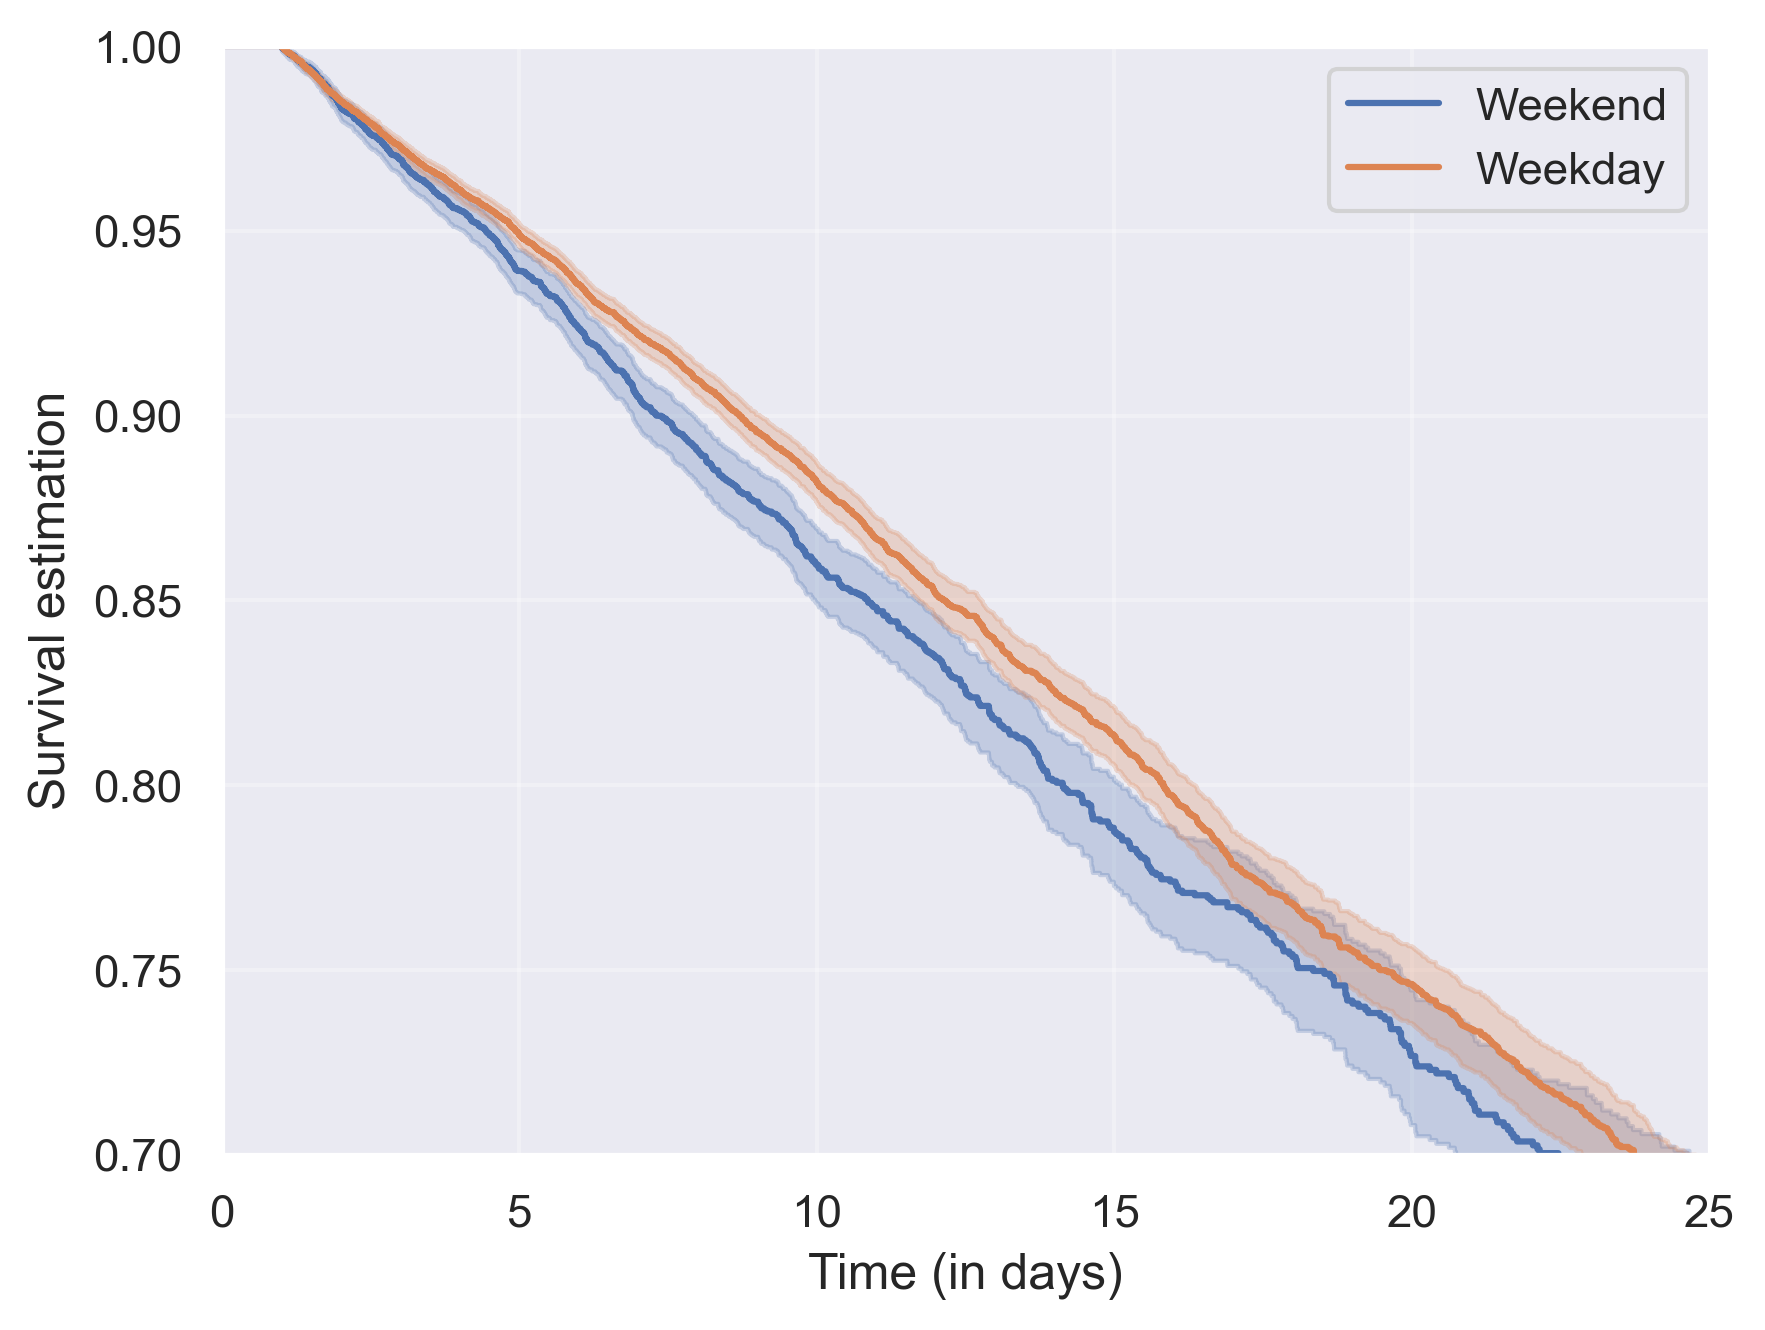

In [17]:
test = labels[periods[0]] != 'External'
kmf = KaplanMeierFitter(label = periods[0])
kmf.fit(outcomes.Time.loc[test], outcomes.Death.loc[test])
kmf.plot()

test = labels[periods[1]] != 'External'
kmf = KaplanMeierFitter(label = periods[1])
kmf.fit(outcomes.Time.loc[test], outcomes.Death.loc[test])
kmf.plot()

plt.grid(alpha = 0.3)
plt.xlabel('Time (in days)')
plt.ylabel('Survival estimation')
plt.xlim(0, 25)
plt.ylim(0.7, 1)

Differencesin observed labels between training and testing 

### All metrics

Evaluate all metrics on datasets

In [18]:
from experiment import *

In [19]:
# Compute and display performances per group of model
models_group = {"Baselines": ["deepsurv"],
                "Sequential": ["lstm"],
                "Time aware": ["gru"],
                "Proposed": ["joint"]}

performances, rocs = {}, {}
for source in labels:
    performances[source], rocs[source] = {}, {}
    for target in labels:
        print('-' * 42)
        print('{} -> {}'.format(source, target))

        performances[source][target], rocs[source][target] = {}, {}
        for group in models_group:
            print('*' * 21)
            print(group)
            
            for model in sorted(predictions[source].keys()):
                if not(any([m in model for m in models_group[group]])):
                    continue
                np.random.seed(42)
                preds = predictions[source][model]

                print(model)

                test = labels[target] == 'Internal' # Use the data that will be used for both   
                test = test[test].index

                train = labels[target] == 'Train' # Use Kaplan meier on the training data of the target
                train = train[train].index

                performances[source][target][model], rocs[source][target][model] = evaluate(outcomes.Death.loc[train].values, outcomes.Remaining.loc[train].values,
                        outcomes.Death.loc[test].values, outcomes.Remaining.loc[test].values,
                        preds.loc[test][[str(h) for h in horizons]].values, horizons = horizons)

------------------------------------------
Weekend -> Weekend
*********************
Baselines
deepsurv_count
Effective iterations:  100
deepsurv_last
Effective iterations:  100
*********************
Sequential
*********************
Time aware
*********************
Proposed
------------------------------------------
Weekend -> Weekday
*********************
Baselines
deepsurv_count


In [ ]:
performances['Random'], rocs['Random'] = {'Random': {}}, {'Random': {}}
for model in sorted(predictions['Random'].keys()):
    np.random.seed(42)
    preds = predictions['Random'][model]

    print(model)

    test = preds.Use != 'Train'
    test = test[test].index

    train = preds.Use == 'Train'
    train = train[train].index

    performances['Random']['Random'][model], rocs['Random']['Random'][model] = evaluate(outcomes.Death.loc[train].values, outcomes.Remaining.loc[train].values,
        outcomes.Death.loc[test].values, outcomes.Remaining.loc[test].values,
        preds.loc[test][[str(h) for h in horizons]].values)

deepsurv_count
Effective iterations:  0
deepsurv_last


/Users/vjeanselme/Desktop/Projects/ClinicalPresence/experiment.py:153: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series({r: result[r] for r in sorted(result)}), cis


Effective iterations:  0


/Users/vjeanselme/Desktop/Projects/ClinicalPresence/experiment.py:153: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series({r: result[r] for r in sorted(result)}), cis


In [ ]:
for source in performances:
    for target in performances[source]:
        print('-' * 42)
        print('{} -> {}'.format(source, target))
        if source == target:
            print(pd.concat(performances[source][source], axis = 1))

        else:
            print(pd.concat(performances[source][target], axis = 1))
            print(pd.concat(performances[source][target], axis = 1) - pd.concat(performances[source][source], axis = 1))


------------------------------------------
Weekend -> Weekend
                              deepsurv_count  deepsurv_last
Brier Score          Mean 1         0.003754       0.003754
                          7         0.100684       0.100684
                          14        0.222290       0.222290
                     Std  1         0.002573       0.002573
                          7         0.014499       0.014499
                          14        0.025071       0.025071
ROC AUC              Mean 1         0.500000       0.500000
                          7         0.500000       0.500000
                          14        0.500000       0.500000
                     Std  1         0.000000       0.000000
                          7         0.000000       0.000000
                          14        0.000000       0.000000
TD Concordance Index Mean 1         0.500000       0.500000
                          7         0.500000       0.500000
                          14        0.

# Comparison Models

Weekend -> Weekend


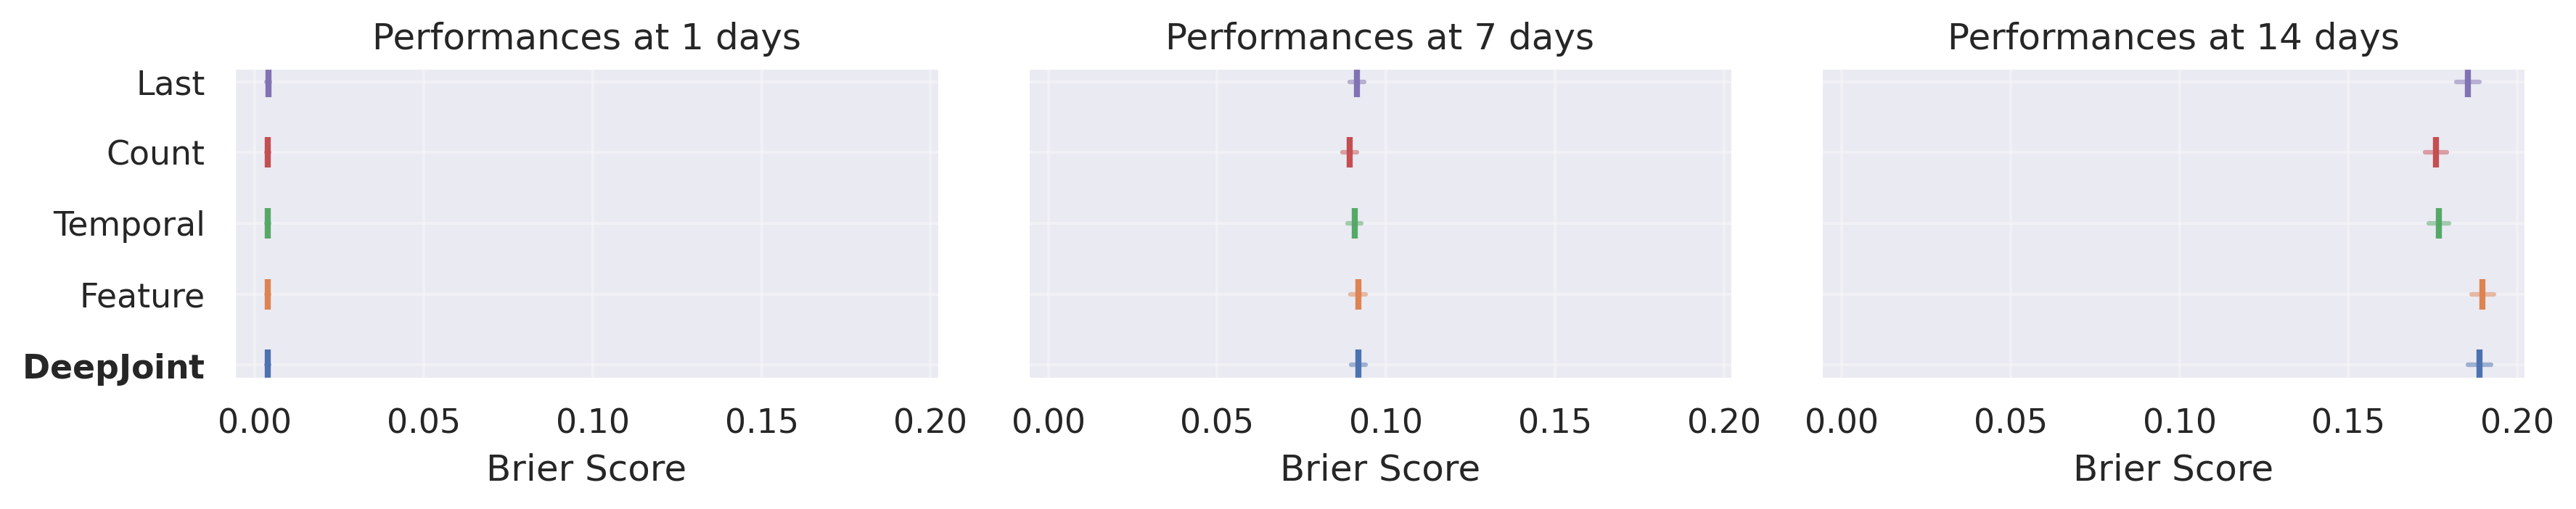

\begin{tabular}{llll}
\toprule
{} &             1  &             7  &             14 \\
\midrule
Last             &  0.004 (0.000) &  0.091 (0.002) &  0.185 (0.003) \\
Count            &  0.004 (0.000) &  0.089 (0.002) &  0.176 (0.003) \\
Temporal         &  0.004 (0.000) &  0.091 (0.002) &  0.177 (0.003) \\
Feature          &  0.004 (0.000) &  0.092 (0.002) &  0.190 (0.003) \\
\$\textbackslash bf\{DeepJoint\}\$ &  0.004 (0.000) &  0.092 (0.002) &  0.189 (0.003) \\
\bottomrule
\end{tabular}

Weekend -> Weekday


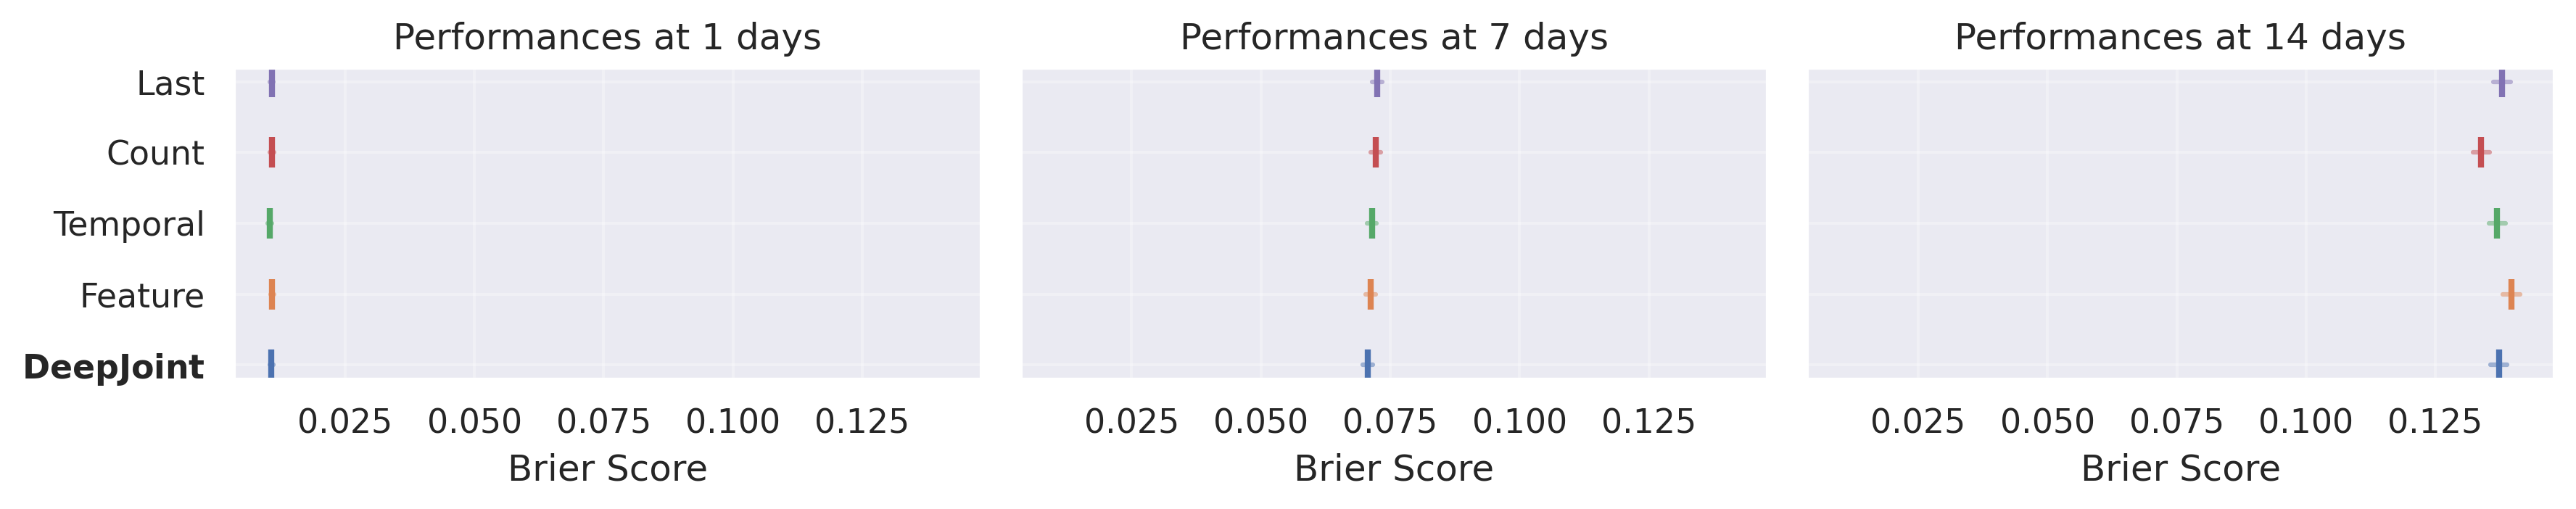

\begin{tabular}{llll}
\toprule
{} &             1  &             7  &             14 \\
\midrule
Last             &  0.011 (0.000) &  0.073 (0.001) &  0.138 (0.002) \\
Count            &  0.011 (0.000) &  0.072 (0.001) &  0.134 (0.002) \\
Temporal         &  0.010 (0.000) &  0.071 (0.001) &  0.137 (0.002) \\
Feature          &  0.011 (0.000) &  0.071 (0.001) &  0.140 (0.002) \\
\$\textbackslash bf\{DeepJoint\}\$ &  0.011 (0.000) &  0.071 (0.001) &  0.137 (0.002) \\
\bottomrule
\end{tabular}

Weekday -> Weekend


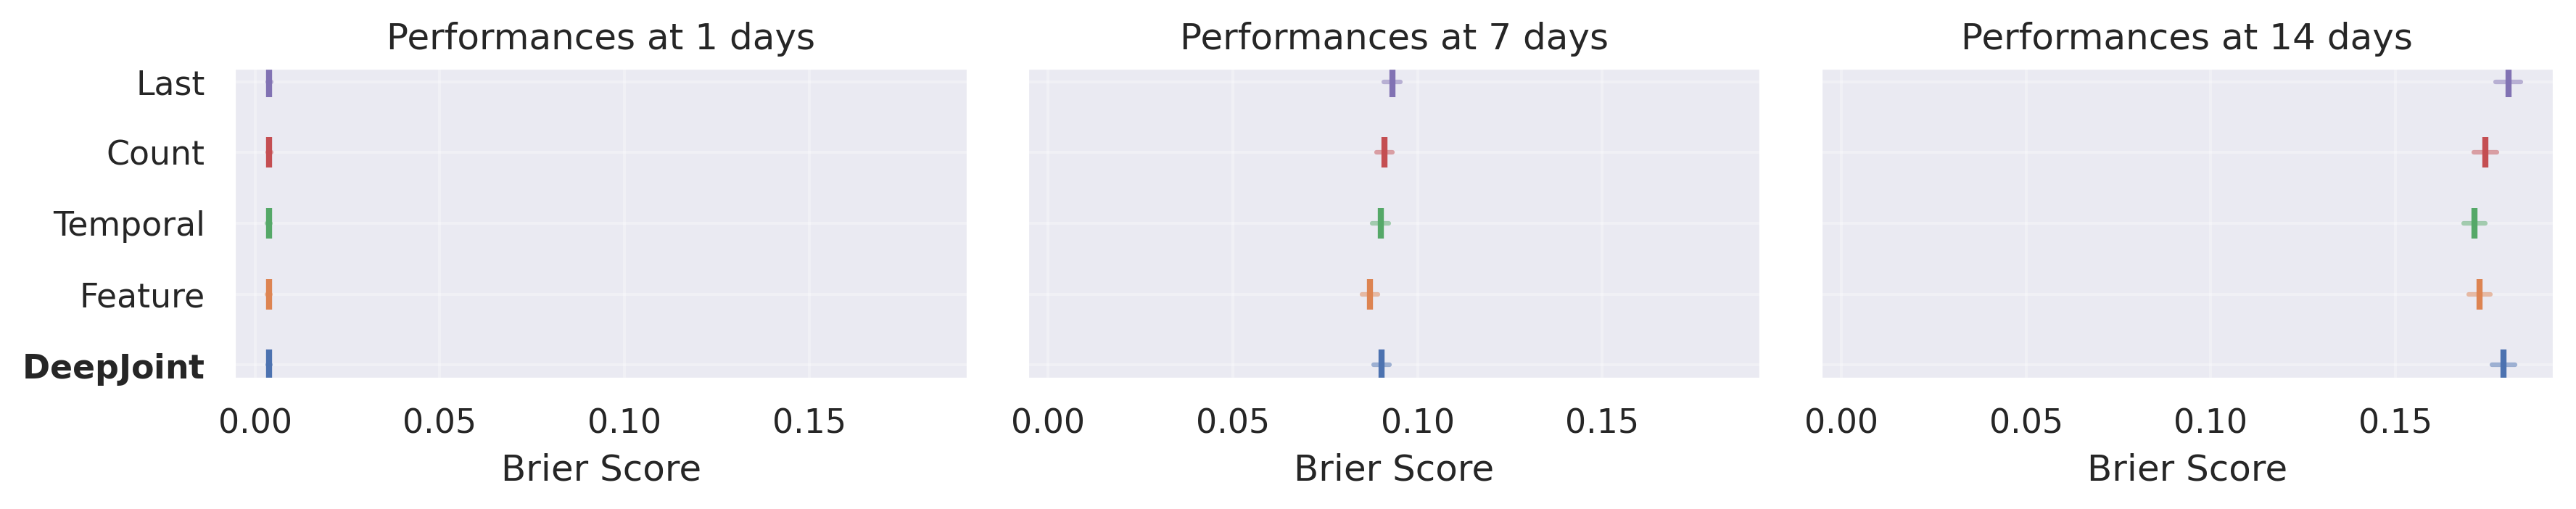

\begin{tabular}{llll}
\toprule
{} &             1  &             7  &             14 \\
\midrule
Last             &  0.004 (0.000) &  0.093 (0.002) &  0.181 (0.003) \\
Count            &  0.004 (0.000) &  0.091 (0.002) &  0.174 (0.003) \\
Temporal         &  0.004 (0.000) &  0.090 (0.002) &  0.171 (0.003) \\
Feature          &  0.004 (0.000) &  0.087 (0.002) &  0.173 (0.003) \\
\$\textbackslash bf\{DeepJoint\}\$ &  0.004 (0.000) &  0.090 (0.002) &  0.179 (0.003) \\
\bottomrule
\end{tabular}

Weekday -> Weekday


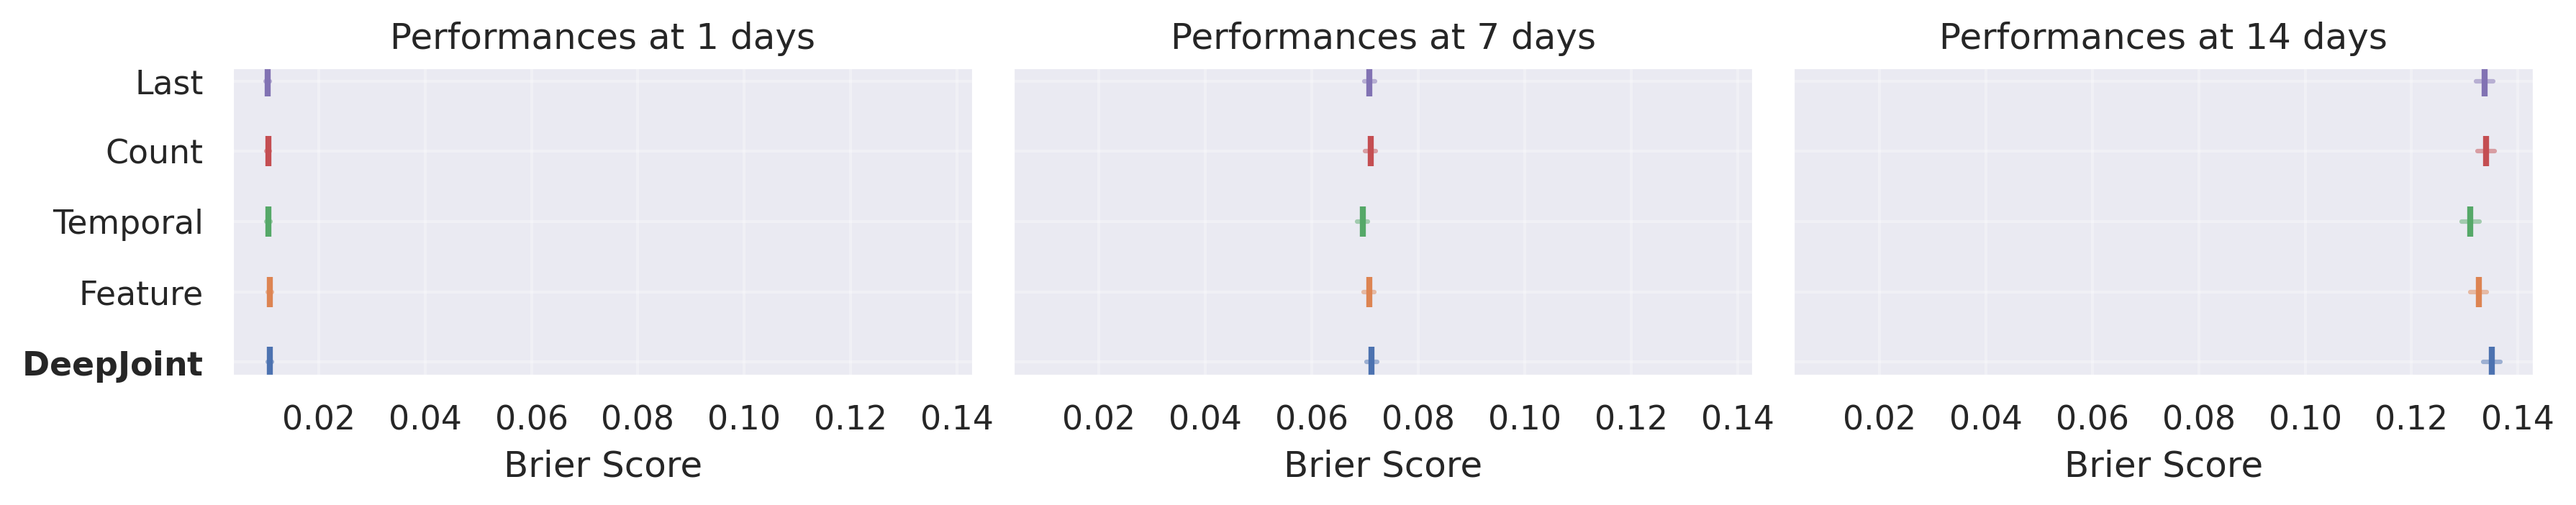

\begin{tabular}{llll}
\toprule
{} &             1  &             7  &             14 \\
\midrule
Last             &  0.010 (0.000) &  0.071 (0.001) &  0.134 (0.002) \\
Count            &  0.011 (0.000) &  0.071 (0.001) &  0.134 (0.002) \\
Temporal         &  0.011 (0.000) &  0.070 (0.001) &  0.131 (0.002) \\
Feature          &  0.011 (0.000) &  0.071 (0.001) &  0.133 (0.002) \\
\$\textbackslash bf\{DeepJoint\}\$ &  0.011 (0.000) &  0.071 (0.001) &  0.135 (0.002) \\
\bottomrule
\end{tabular}

Random -> Random


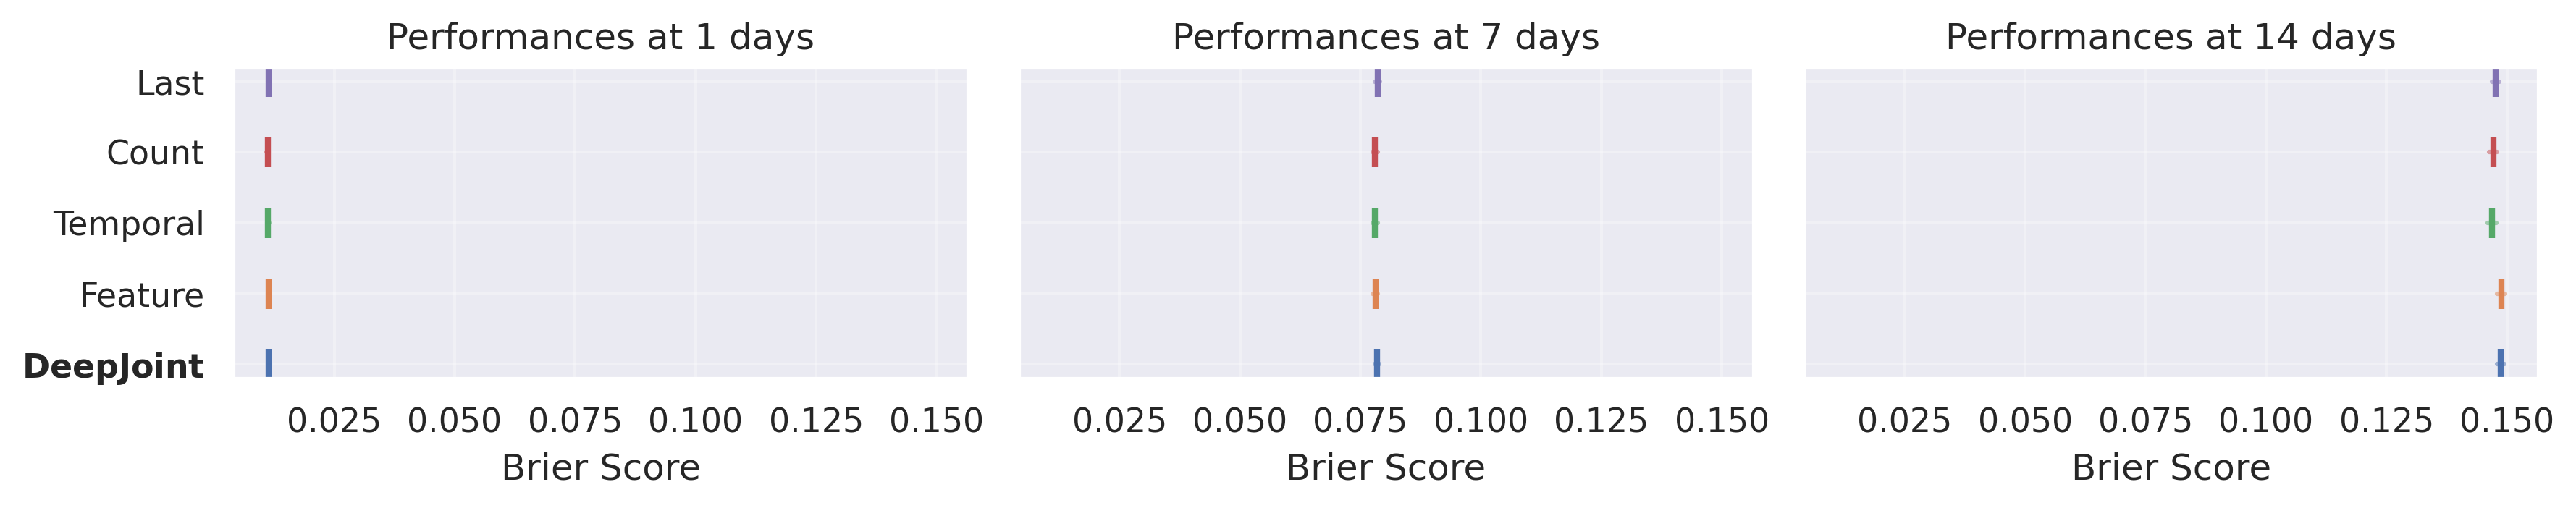

\begin{tabular}{llll}
\toprule
{} &             1  &             7  &             14 \\
\midrule
Last             &  0.011 (0.000) &  0.079 (0.000) &  0.148 (0.001) \\
Count            &  0.011 (0.000) &  0.078 (0.000) &  0.147 (0.001) \\
Temporal         &  0.011 (0.000) &  0.078 (0.000) &  0.147 (0.001) \\
Feature          &  0.011 (0.000) &  0.078 (0.000) &  0.149 (0.001) \\
\$\textbackslash bf\{DeepJoint\}\$ &  0.011 (0.000) &  0.078 (0.000) &  0.149 (0.001) \\
\bottomrule
\end{tabular}



In [ ]:
plot = "Brier Score" #"ROC AUC""Brier Score""TD Concordance Index"

for source in performances:
    for target in performances[source]:
        performances_display = {
            #r"$\bf{DeepJointFineTune}$": performances[source][target]['joint_full_finetune_value+time+mask'][plot],
            r"$\bf{DeepJoint}$": performances[source][target]['joint_value+time+mask'][plot],
            "Feature": performances[source][target]['lstm_value+time+mask'][plot],
            "Temporal": performances[source][target]['lstm_value'][plot],
            #"GRU-D": performances[source][target]['gru_d+mask'][plot],
            #r"$\bf{DeepJoint}$": performances[source][target]['joint+value'][plot],
            #"Resample": performances[source][target]['lstm+resampled'][plot],
            #"Ignore": performances[source][target]['lstm_value'][plot],
            "Count": performances[source][target]['deepsurv_count'][plot],
            "Last": performances[source][target]['deepsurv_last'][plot],
        }

        performances_display = pd.concat(performances_display, axis = 1)

        #plt.rcParams.update({'font.size': 12})
        fig, axes = plt.subplots(ncols = len(horizons), sharey = True, sharex = True, figsize=(12,2.5))
        print("{} -> {}".format(source, target))
        for i, ax in zip(horizons, axes):
            perf_metric_mean = performances_display.loc['Mean', i]
            perf_metric_std = 1.96 * performances_display.loc['Std', i] / np.sqrt(iters)
            for j, model in enumerate(performances_display.columns):
                p = ax.plot((perf_metric_mean[model] + perf_metric_std[model], perf_metric_mean[model] - perf_metric_std[model]), (j, j), alpha = 0.5)
                ax.scatter(perf_metric_mean[model], j, s = 100, label = model, marker = '|', color = p[-1].get_color(),linewidths = 2)
                
            ax.grid(alpha = 0.3)
            ax.set_yticks(range(len(performances_display.columns)))
            ax.set_yticklabels(performances_display.columns)
            ax.set_title('Performances at {} days'.format(i))
            ax.set_xlabel(plot)
        plt.tight_layout()
        plt.show()

        print(pd.DataFrame.from_dict({m: ["{:.3f} ({:.3f})".format(performances_display.loc['Mean'].loc[m].loc[i], 1.96 * performances_display.loc['Std'].loc[m].loc[i] / np.sqrt(iters)) for i in performances_display.loc['Mean'].columns] for m in performances_display.loc['Mean'].index}, columns = performances_display.columns, orient = 'index').T.loc[::-1].to_latex())

# Comparison predictions

In [ ]:
import seaborn as sns

In [ ]:
names = {
    'joint+value': 'Deep Joint Model on labs',
    'lstm_value+time+mask' : 'DeepSurv on labs, time and mask',
}

x, y = 'joint+value', 'lstm_value+time+mask'
horizon = '7'

In [ ]:
data = {
    'Censored by {} day'.format(horizon): outcomes[(~outcomes.Death) & (outcomes.LOS < int(horizon))].index,
    'Dead by {} day'.format(horizon): outcomes[outcomes.Death & (outcomes.LOS < int(horizon))].index,
    'Alive at {} day'.format(horizon): outcomes[outcomes.LOS > int(horizon)].index,
}

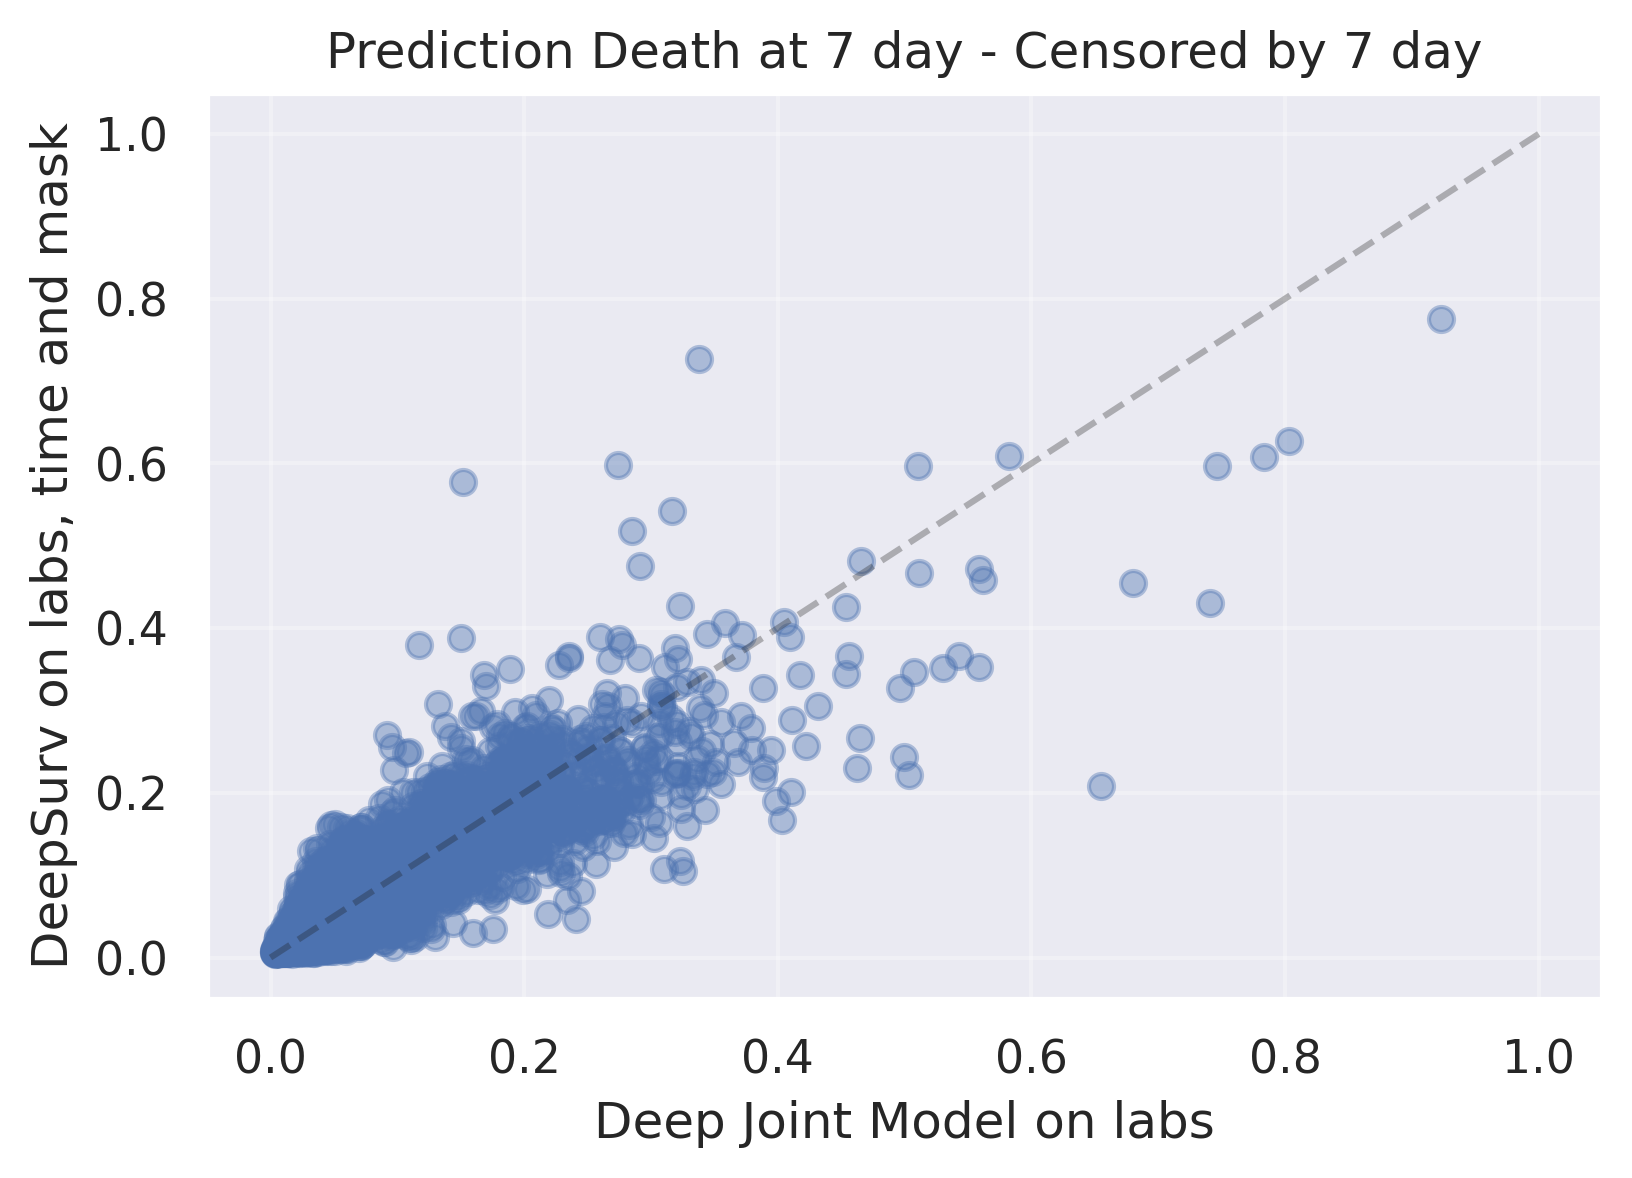

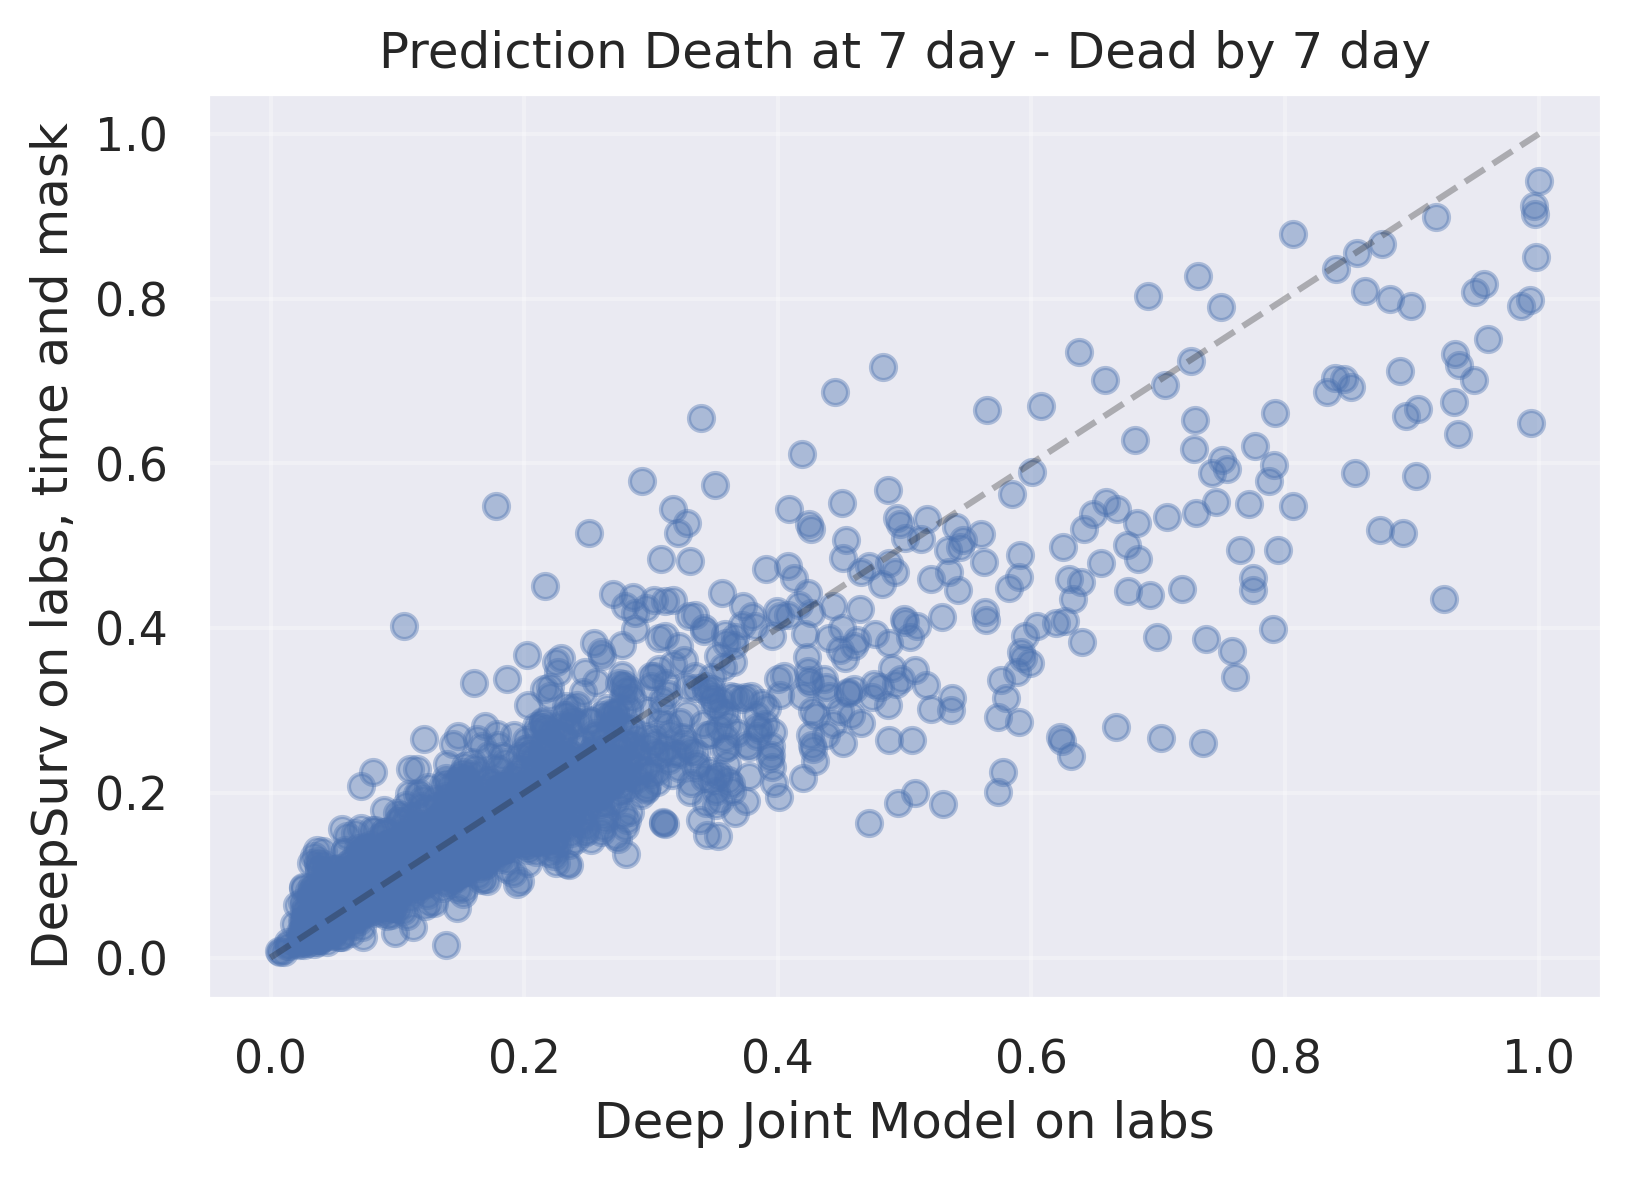

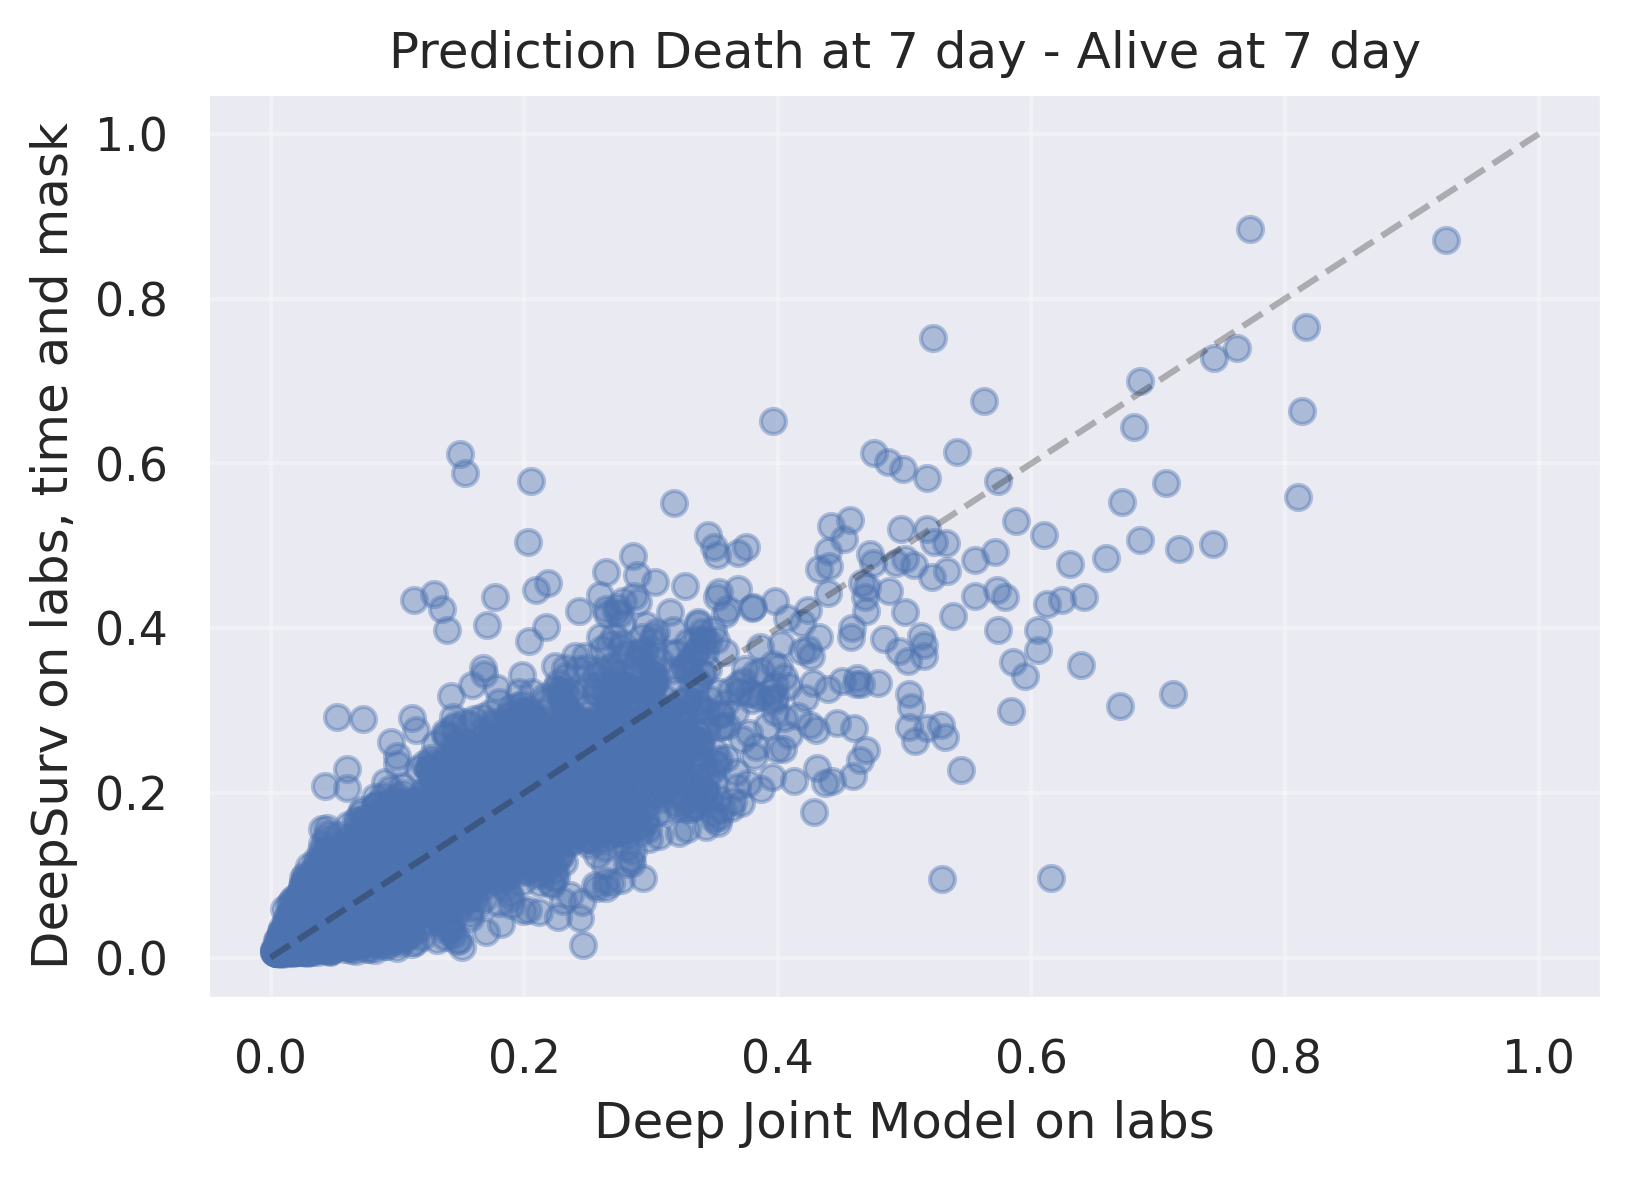

In [ ]:
for cat in data:
    plt.figure()
    #sns.kdeplot(x=predictions['Random'][x][horizon].loc[data[cat]], y=predictions['Random'][y][horizon].loc[data[cat]], fill=True)
    plt.scatter(predictions['Random'][x][horizon].loc[data[cat]], predictions['Random'][y][horizon].loc[data[cat]], alpha = 0.4)

    plt.xlabel(names[x])
    plt.ylabel(names[y])
    plt.plot([0, 1], [0, 1], ls = '--', alpha = 0.3, c = 'k')
    plt.title('Prediction Death at {} day - {}'.format(horizon, cat))
    plt.grid(alpha = 0.3)
    plt.show()

# Comparison between weekend and weekdays

In [ ]:
plot = "TD Concordance Index" #"ROC AUC""Brier Score""TD Concordance Index"

performances_display = {
    s :{
        t: {
            #r"$\bf{DeepJointFineTune}$": performances[s][t]['joint_full_finetune_value+time+mask'][plot],
            r"$\bf{DeepJoint}$": performances[s][t]['joint_value+time+mask'][plot],
            "Feature": performances[s][t]['lstm_value+time+mask'][plot],
            "Temporal": performances[s][t]['lstm_value'][plot],
            "Count": performances[s][t]['deepsurv_count'][plot],
            "Last": performances[s][t]['deepsurv_last'][plot],
        }
        for t in performances[s]
    }
    for s in periods
}

rocs_display = {
    s :{
        t: {
            r"$\bf{DeepJointFineTune}$": rocs[s][t]['joint_full_finetune_value+time+mask'],
            r"$\bf{DeepJointFeature}$": rocs[s][t]['joint_value+time+mask'],
            "Feature": rocs[s][t]['lstm_value+time+mask'],
            "GRU-D": rocs[s][t]['gru_d+mask'],
            r"$\bf{DeepJoint}$": rocs[s][t]['joint+value'],
            "Resample": rocs[s][t]['lstm+resampled'],
            "Ignore": rocs[s][t]['lstm_value'],
            "Count": rocs[s][t]['deepsurv_count'],
            "Last": rocs[s][t]['deepsurv_last'],
        }
        for t in rocs[s]
    }
    for s in periods
}


In [ ]:
horizons= [1, 7, 14]

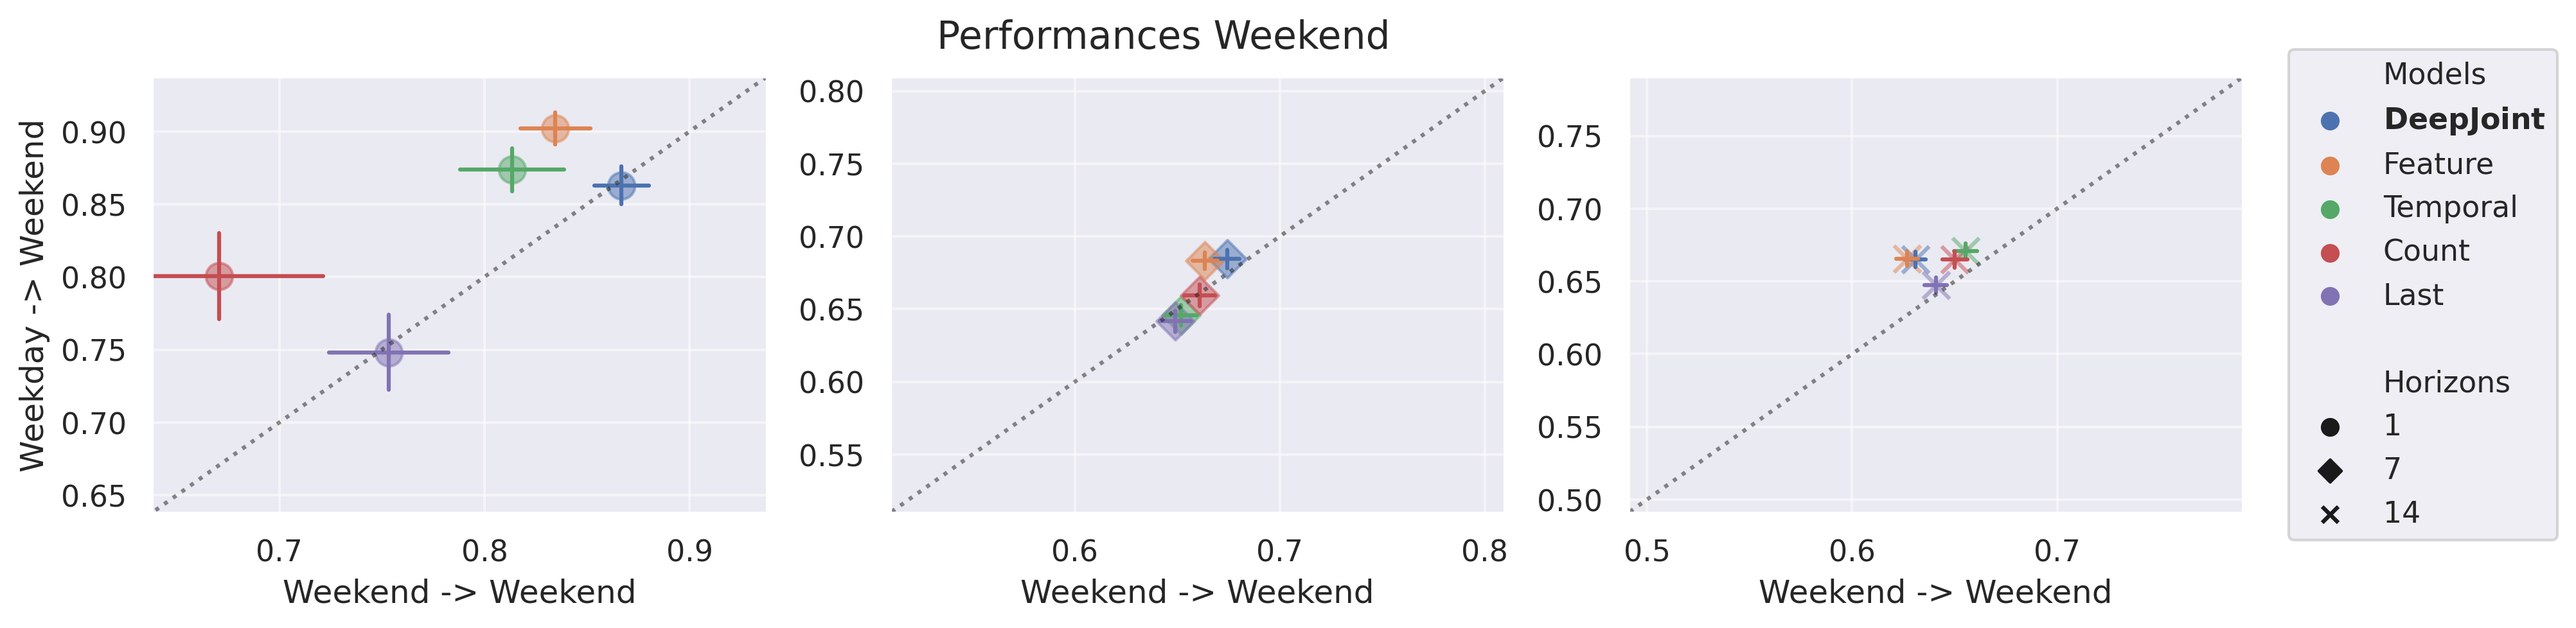

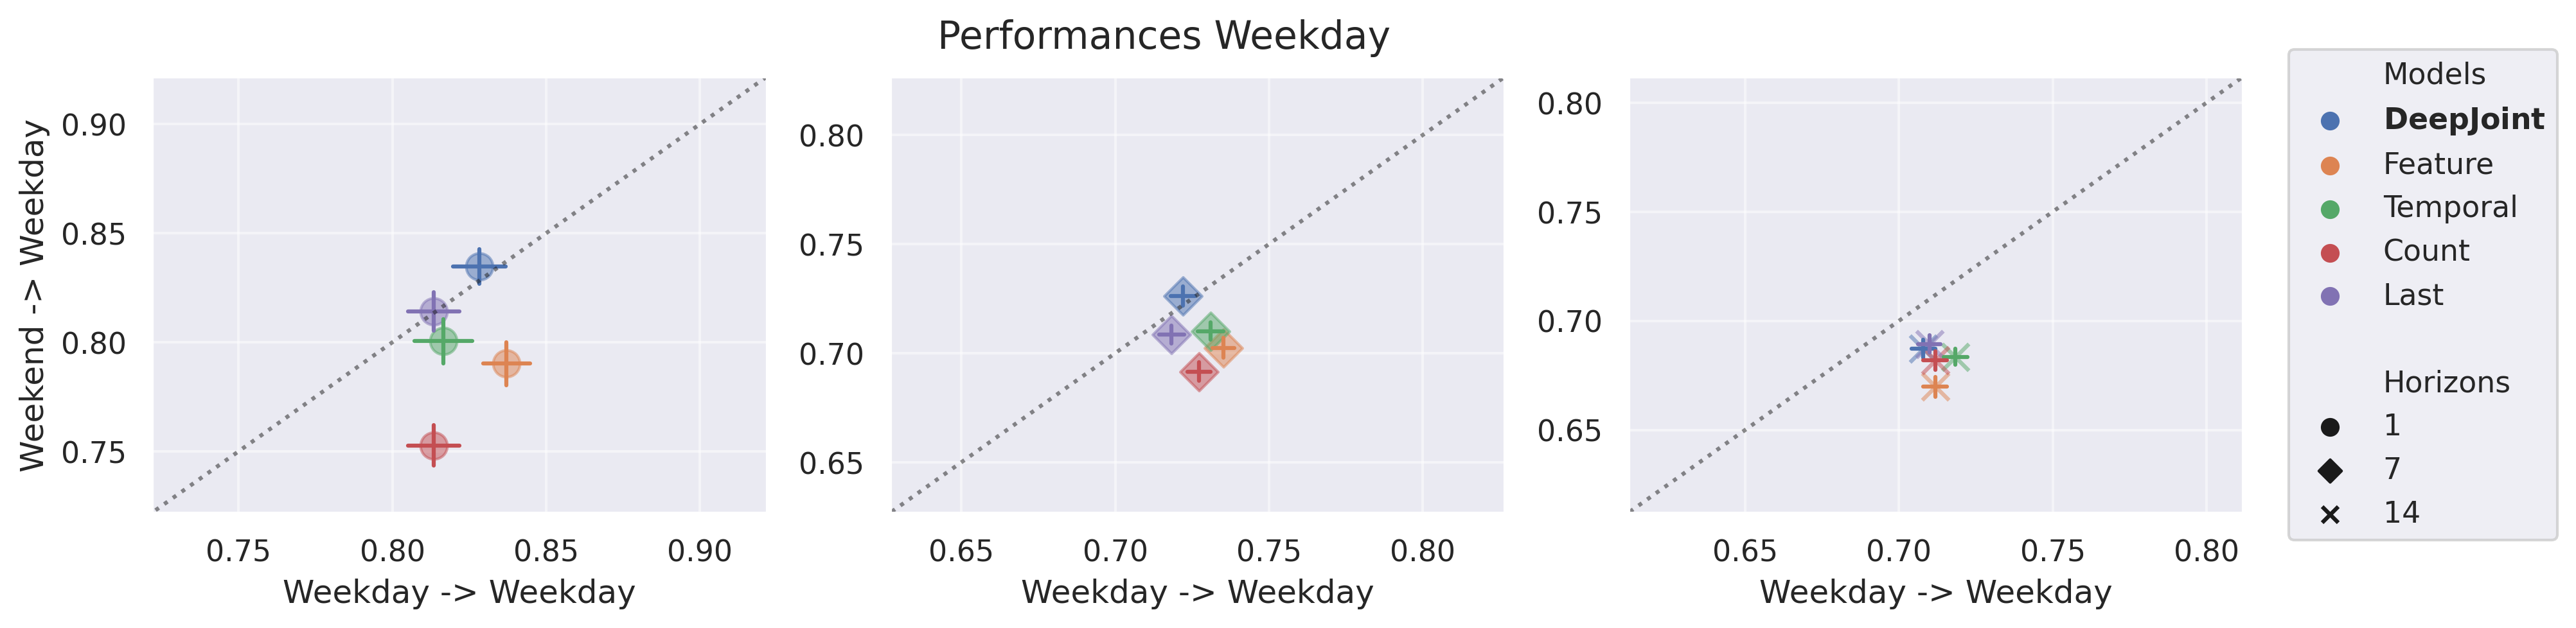

In [ ]:
# Plot double barh to display performances
### Create dfs of mean and std
for time in performances_display:
    opposite = periods[1] if time == periods[0] else periods[0]

    transfer = "{} -> {}".format(opposite, time)
    training = "{} -> {}".format(time, time)

    fig, axes = plt.subplots(ncols = len(horizons), figsize = (14, 3))
    
    axes[0].set_ylabel(transfer)
    fig.suptitle('Performances {}'.format(time))

    for ax, i, m in zip(axes, horizons, ['o', 'D', 'x', '.']):
        perf_metric_mean = pd.DataFrame({
                    transfer : pd.concat(performances_display[opposite][time], axis = 1).loc['Mean', i],
                    training : pd.concat(performances_display[time][time], axis = 1).loc['Mean', i]
                })
        perf_metric_std = 1.96 * pd.DataFrame({
                    transfer : pd.concat(performances_display[opposite][time], axis = 1).loc['Std', i],
                    training : pd.concat(performances_display[time][time], axis = 1).loc['Std', i]
                }) / np.sqrt(iters)
        colors = list(plt.rcParams['axes.prop_cycle'])
        #colors[3] = colors[8]
        for model, c in zip(perf_metric_mean.index, colors[:len(perf_metric_mean)]):
            ax.scatter(perf_metric_mean.loc[model][training], perf_metric_mean.loc[model][transfer], color = c['color'], marker = m, alpha = 0.5, s = 100)
            ax.plot([perf_metric_mean.loc[model][training] - perf_metric_std.loc[model][training], perf_metric_mean.loc[model][training] + perf_metric_std.loc[model][training]], [perf_metric_mean.loc[model][transfer], perf_metric_mean.loc[model][transfer]], color = c['color'])
            ax.plot([perf_metric_mean.loc[model][training], perf_metric_mean.loc[model][training]], [perf_metric_mean.loc[model][transfer] - perf_metric_std.loc[model][transfer], perf_metric_mean.loc[model][transfer] + perf_metric_std.loc[model][transfer]], color = c['color'])

        ax.plot([0, 1], [0, 1], color = 'k', ls = ':', alpha = 0.5)
        ax.set_xlabel(training)
        ax.grid(alpha = 0.5)

        means = perf_metric_mean.mean()
        margin = 0.1 if time == 'Weekday' else 0.15
        ax.set_xlim(means[training] - margin, means[training] + margin)
        ax.set_ylim(means[training] - margin, means[training] + margin)
    else:
        # Display
        ## Legend
        plt.scatter([],[], alpha = 0., label = "Models")
        for model, c in zip(perf_metric_mean.index, colors[:len(perf_metric_mean)]):
            plt.scatter([],[], color = c['color'], label = model)
        plt.scatter([],[], alpha = 0., label = " ")
        plt.scatter([],[], alpha = 0., label = "Horizons")
        for i, m in zip(horizons, ['o', 'D', 'x', '.']):
            plt.scatter([],[], marker = m, label = i, color = 'k')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        plt.show()

    

In [ ]:
for time in rocs_display:
    opposite = periods[1] if time == periods[0] else periods[0]

    transfer = "{} -> {}".format(opposite, time)
    training = "{} -> {}".format(time, time)
    print(transfer, training)
    rocs_diff = {}
    for model in rocs_display[opposite][time]:
        rocs_diff[model] = {}
        for t in rocs_display[opposite][time][model]:
            diff = np.array(rocs_display[opposite][time][model][t]) - np.array(rocs_display[time][time][model][t])
            rocs_diff[model][('Mean', t)] = np.mean(diff)
            rocs_diff[model][('Std', t)] = 1.96 * np.std(diff) / np.sqrt(len(diff))
 
    print(pd.DataFrame.from_dict({m: ["{:.3f} ({:.3f})".format(rocs_diff[m][('Mean', i)], rocs_diff[m][('Std', i)]) for i in horizons] for m in rocs_diff}, columns = horizons, orient = 'index').loc[::-1].to_latex())

Weekday -> Weekend Weekend -> Weekend
\begin{tabular}{llll}
\toprule
{} &              1  &              7  &             14 \\
\midrule
Last                     &  -0.005 (0.009) &  -0.007 (0.005) &  0.007 (0.003) \\
Count                    &   0.130 (0.023) &  -0.001 (0.004) &  0.015 (0.004) \\
Ignore                   &   0.060 (0.029) &  -0.006 (0.005) &  0.016 (0.003) \\
Resample                 &   0.058 (0.012) &   0.005 (0.006) &  0.046 (0.004) \\
\$\textbackslash bf\{DeepJoint\}\$         &   0.071 (0.011) &   0.014 (0.005) &  0.030 (0.003) \\
GRU-D                    &   0.003 (0.010) &   0.028 (0.004) &  0.039 (0.004) \\
Feature                  &   0.068 (0.013) &   0.020 (0.004) &  0.039 (0.003) \\
\$\textbackslash bf\{DeepJointFeature\}\$  &  -0.004 (0.002) &   0.010 (0.004) &  0.034 (0.004) \\
\$\textbackslash bf\{DeepJointFineTune\}\$ &   0.017 (0.003) &   0.003 (0.004) &  0.033 (0.004) \\
\bottomrule
\end{tabular}

Weekend -> Weekday Weekday -> Weekday
\begin{tabular}

# Display distance to diagonal

Performance Model Weekend - Performance Model Weekday on Weekend patients


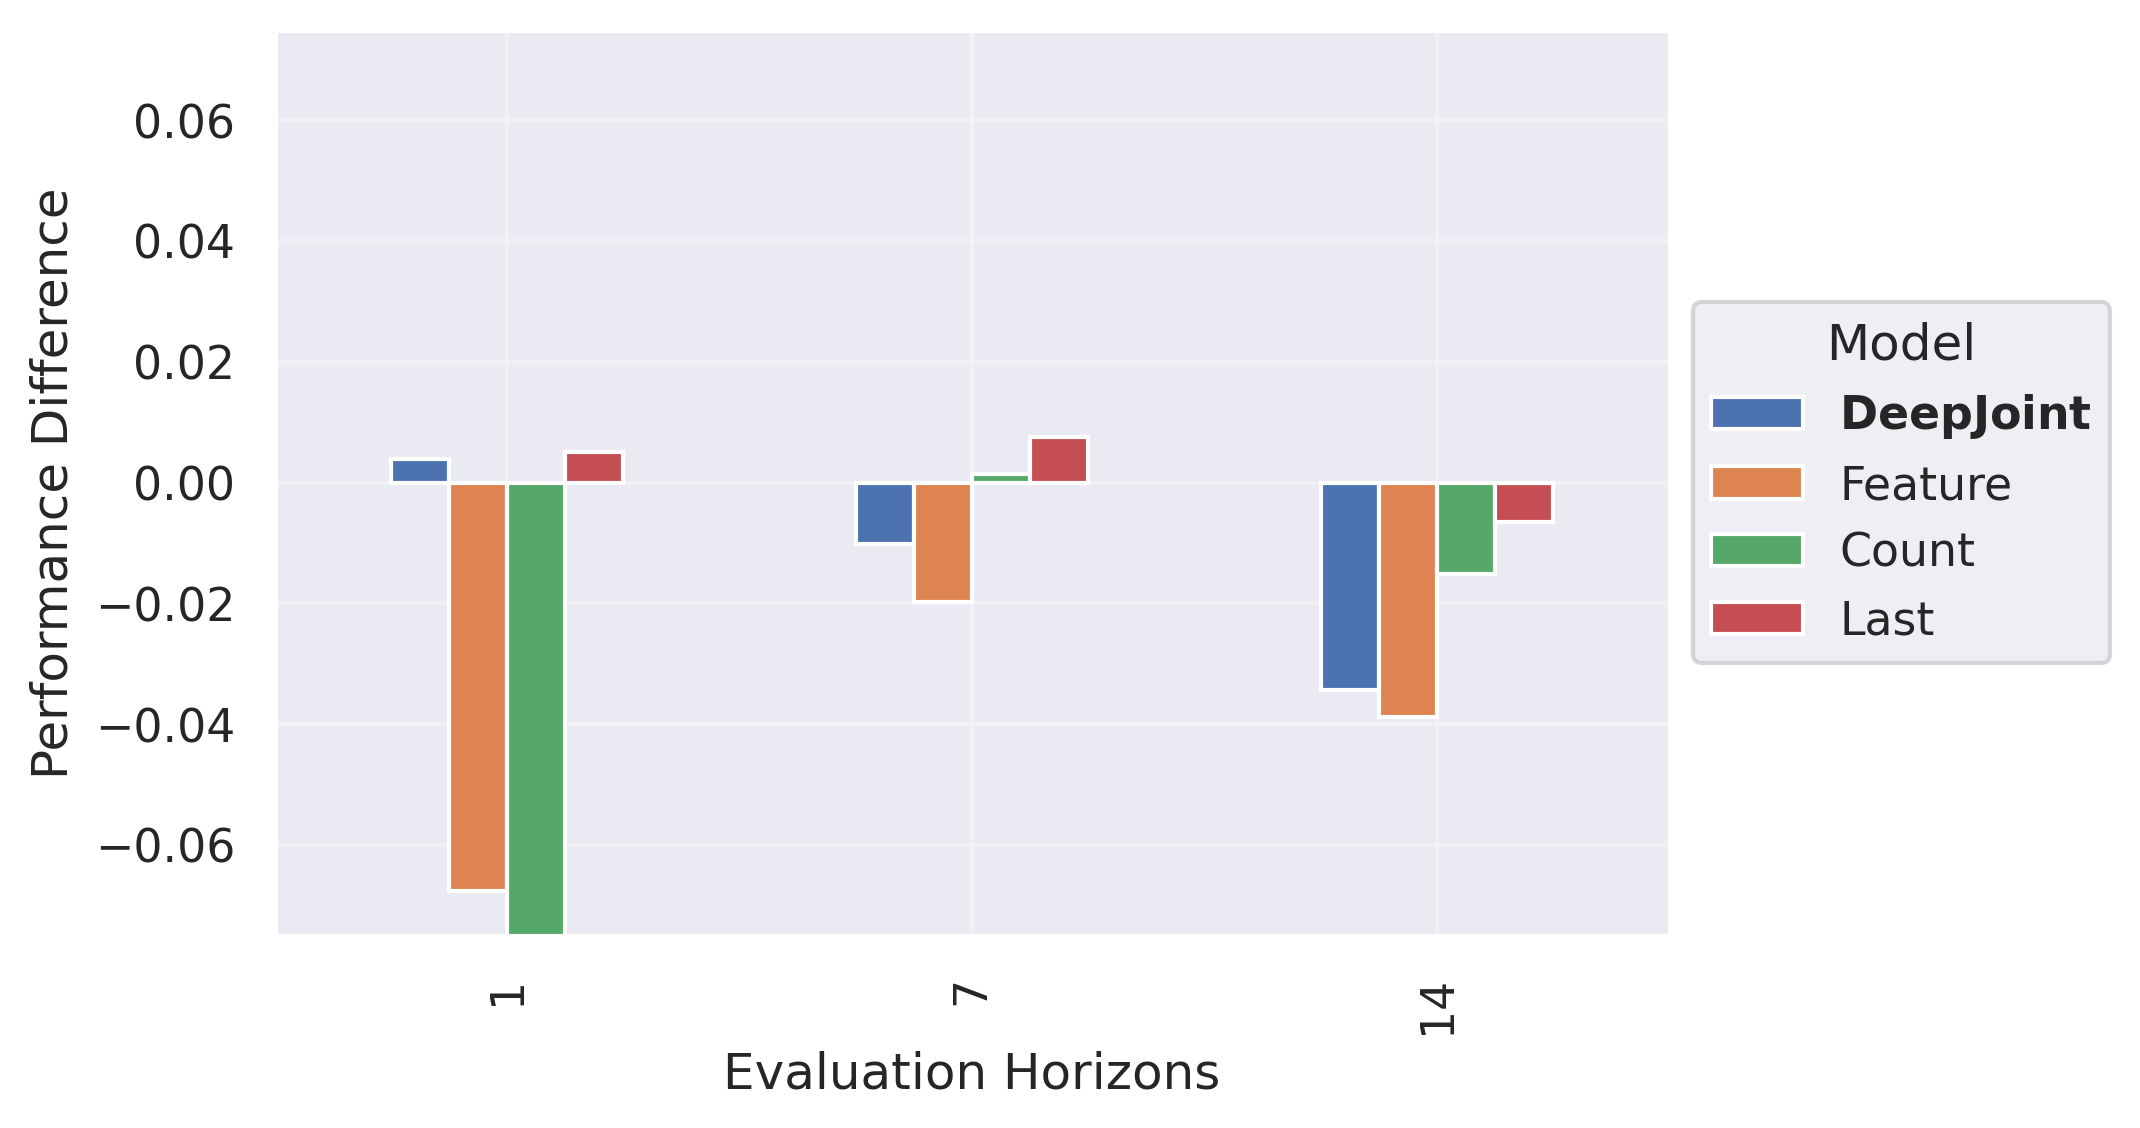

Performance Model Weekday - Performance Model Weekend on Weekday patients


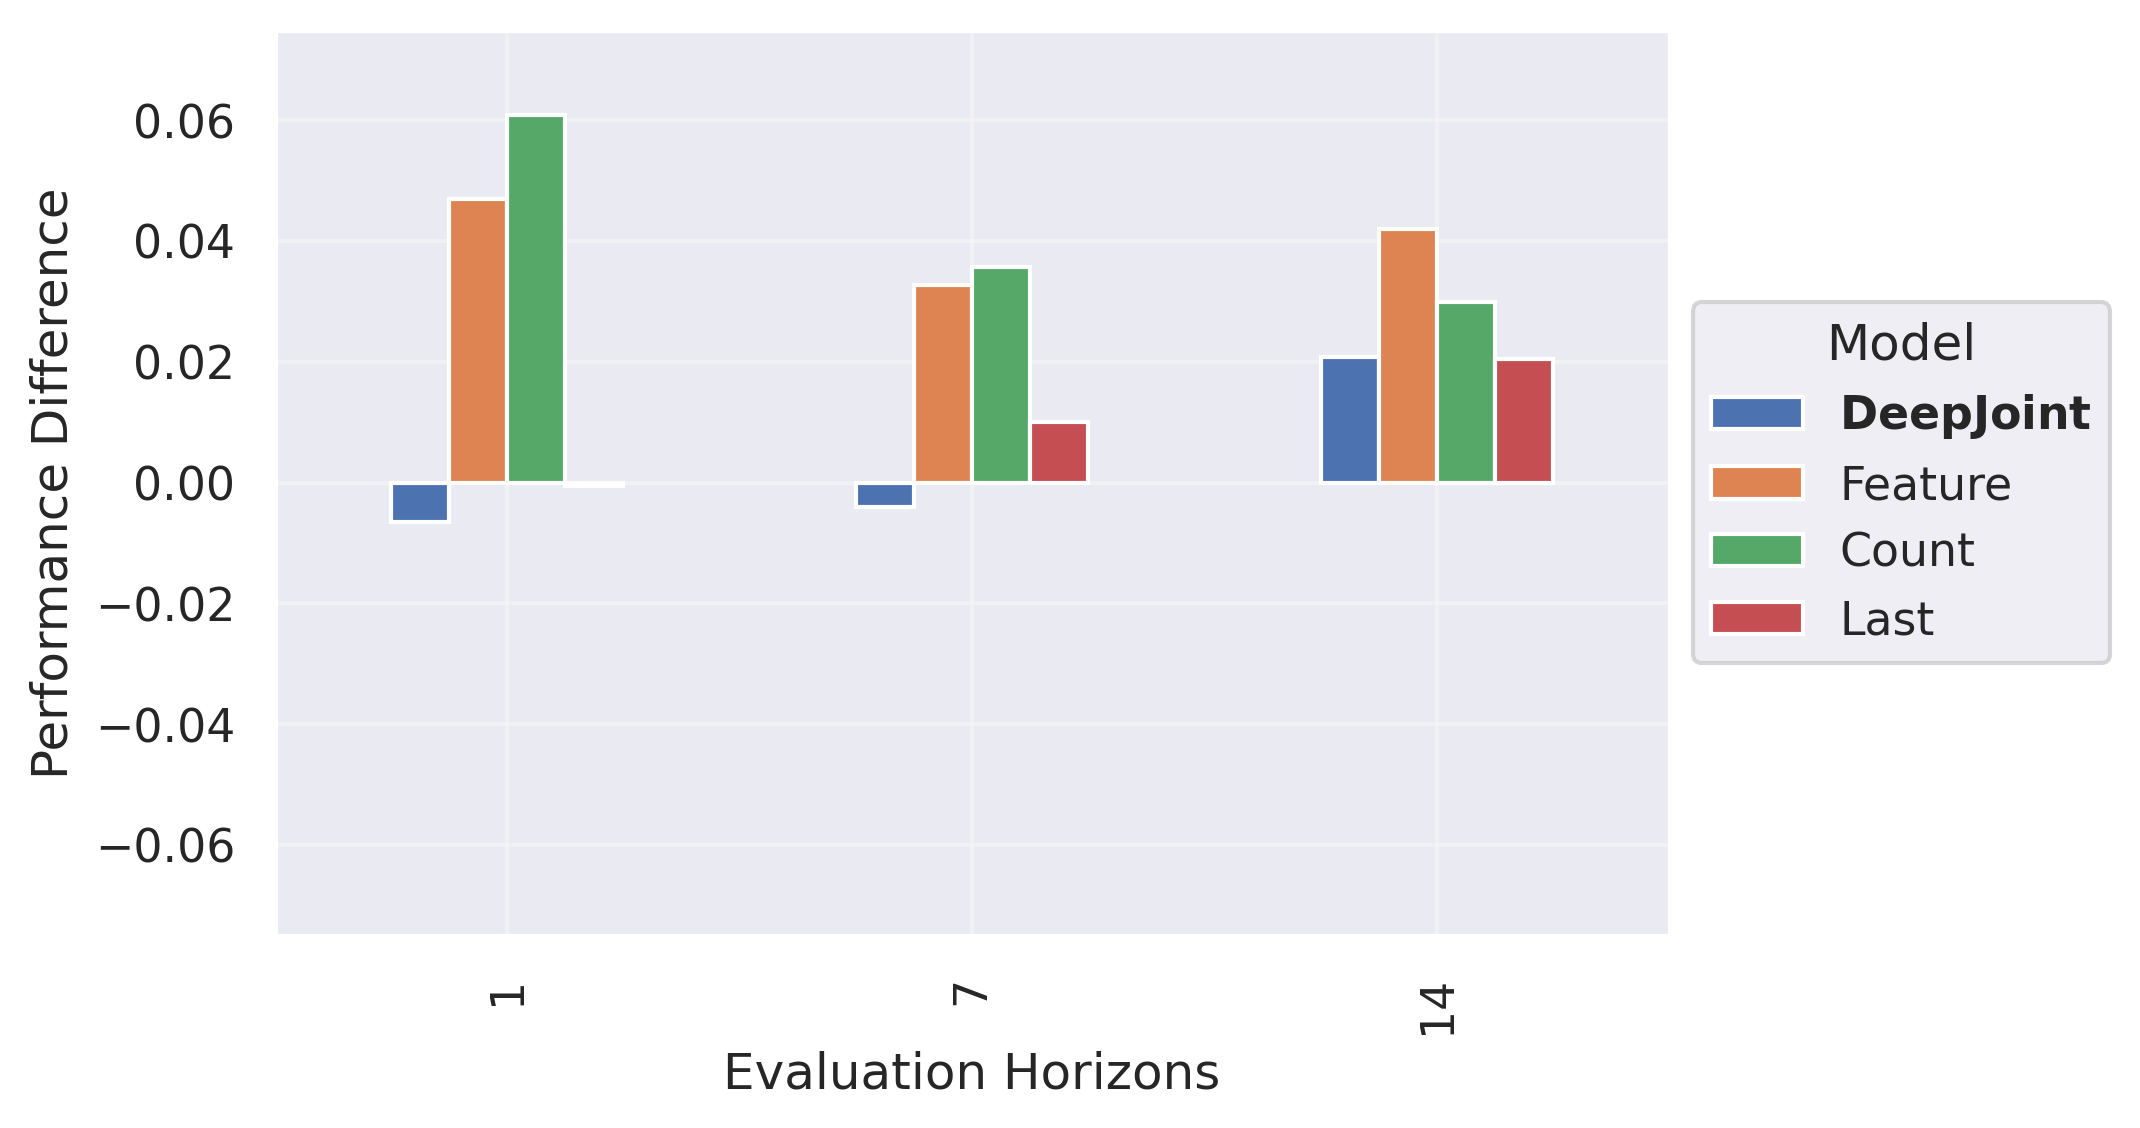

In [ ]:
for time in performances_display:
    opposite = periods[1] if time == periods[0] else periods[0]

    transfer = "{} -> {}".format(opposite, time)
    training = "{} -> {}".format(time, time)

    perf_metric_diff = pd.concat(performances_display[time][time], axis = 1).loc['Mean'] - pd.concat(performances_display[opposite][time], axis = 1).loc['Mean']
    perf_metric_diff.plot.bar()

    print('Performance Model {} - Performance Model {} on {} patients'.format(time, opposite, time))
    plt.xlabel('Evaluation Horizons')
    plt.ylabel('Performance Difference')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Model')
    plt.grid(alpha = 0.3)
    plt.ylim(-0.075, 0.075)
    plt.show()
